# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [0]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-04-08 14:52:22--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533309 (521K) [text/plain]
Saving to: ‘russian-train-high’

russian-train-high  100%[===================>] 520.81K  --.-KB/s    in 0.08s   

2020-04-08 14:52:22 (6.20 MB/s) - ‘russian-train-high’ saved [533309/533309]

--2020-04-08 14:52:23--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [0]:
import io

def read_infile(infile):
    with io.open(infile, encoding='utf-8') as file:
        words = list(set(map(lambda line: line.split('\t')[1].replace(' ', ''), file.readlines())))
    return words

In [0]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

9923 999 998
расплатилась распечатали калибры гребные перебежчикам атомное нобелевского беззакония стынь подоспев


**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [0]:
import torch.nn as nn

In [0]:
import itertools
from torch.utils.data import Dataset

In [0]:
class Vocabulary():
    def __init__(self, special_tokens=None):
        self.i2t = {}
        self.t2i = {}
        self.special_tokens = special_tokens
        self.count = 0

    def fit(self, tokens):
        if self.special_tokens is not None:
            tokens = self.special_tokens + tokens
        
        for token in itertools.chain(*tokens):
            token = token.lower()
            if token not in self.t2i.keys():
                self.t2i[token] = self.count
                self.i2t[self.count] = token
                self.count += 1
    
    def __len__(self):
        return self.count + 1

    def __call__(self, batch):
        indices_batch = []
        
        for sample in batch:
            indices_batch.append([self.t2i[token.lower()] for token in sample])
        
        return indices_batch
    
    def get_word(self, idx):
      return list(map(lambda x: self.i2t[x], idx))

In [0]:
vocab = Vocabulary(special_tokens=[['END', 'BEGIN', "PAD"]])
full_seq = train_words + dev_words + test_words
vocab.fit([list(x) for x in full_seq])
print(len(vocab))
print(vocab(
    [['а', 'б', 'в'], ['г'], ['ф', 'а'], ["END", 'BEGIN', 'PAD']]
))

38
[[4, 14, 21], [16], [31, 4], [0, 1, 2]]


**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [0]:
class Dataset(Dataset):
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __getitem__(self, index):
        word = torch.LongTensor(self.vocab([['BEGIN'] + list(self.data[index]) + ['END']]))[0]
        return ([word[:-1], word[1:]])

    def __len__(self):
        return len(self.data)

In [0]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

len(train_dataset), len(dev_dataset), len(test_dataset)

(9923, 999, 998)

**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [0]:
from torch.utils.data import DataLoader
import torch

cnt = 0
loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

for x, y in loader:
    print(x.shape, y.shape)
    cnt += 1
    if cnt >= 10:
        break

torch.Size([1, 13]) torch.Size([1, 13])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 13]) torch.Size([1, 13])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 13]) torch.Size([1, 13])
torch.Size([1, 11]) torch.Size([1, 11])
torch.Size([1, 6]) torch.Size([1, 6])
torch.Size([1, 9]) torch.Size([1, 9])


**(1.5) 1 point** Explain, why this does not work with larger batch size.

##### It does not work because the sizes of words different. However DataLoader expects the elements in batch with the same shape.

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [0]:
import torch.nn.functional as F


def pad_tensor(vec, length, pad_symbol):
    x = torch.stack(
        tuple(
            map(
                lambda x: torch.cat([x[0], torch.LongTensor([pad_symbol] * max(length - x[0].shape[0], 0))]), 
                vec
            )
        ), 
        0
    )
    
    y = torch.stack(
        tuple(
            map(
                lambda x: torch.cat([x[1], torch.LongTensor([pad_symbol] * max(length - x[1].shape[0], 0))]), 
                vec
            )
        ), 
        0
    )
    return (x, y)

class Padder:
    def __init__(self, pad_symbol=0):
        self.pad_symbol = pad_symbol
        
    def __call__(self, batch):
        max_size = max(map(lambda x: len(x[1]), batch))
        return pad_tensor(batch, max_size, self.pad_symbol)

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [0]:
from torch.utils.data import DataLoader

cnt = 0
PAD_TOKEN = train_dataset.vocab([['PAD']])[0][0]
print(PAD_TOKEN)
loader = DataLoader(train_dataset, batch_size=10, collate_fn=Padder(pad_symbol=PAD_TOKEN))

for x, y in loader:
    print(x.shape, y.shape)
    cnt += 1
    if cnt >= 10:
        break

2
torch.Size([10, 13]) torch.Size([10, 13])
torch.Size([10, 19]) torch.Size([10, 19])
torch.Size([10, 16]) torch.Size([10, 16])
torch.Size([10, 16]) torch.Size([10, 16])
torch.Size([10, 17]) torch.Size([10, 17])
torch.Size([10, 15]) torch.Size([10, 15])
torch.Size([10, 16]) torch.Size([10, 16])
torch.Size([10, 21]) torch.Size([10, 21])
torch.Size([10, 18]) torch.Size([10, 18])
torch.Size([10, 20]) torch.Size([10, 20])


## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [0]:
import torch.nn as nn

class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size):
        super(RNNLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embeddings_dim) # maybe add pad_idx
        self.GRU = nn.GRU(embeddings_dim, hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        output, hidden = self.GRU(inputs)
        output = self.softmax(self.linear(output))
        hidden = self.softmax(self.linear(hidden))
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        self.hidden = torch.zeros([1, batch_size, self.hidden_size])

**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [0]:
import numpy as np

In [0]:
def validate_on_batch(model, criterion, x, y):
    res, _ = model(x)
    
    return criterion(res.view(np.prod(y.shape), -1), y.view(np.prod(y.shape)))

**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [0]:
def train_on_batch(model, criterion, x, y, optimizer):
    optimizer.zero_grad()
    
    loss = validate_on_batch(model, criterion, x, y)
    
    loss.backward()
    
    optimizer.step()
    
    return loss

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

In [0]:
import torch.optim 

embedding_dim = 256
hidden_size = 128
lr = 10e-3

num_epoch = 4
batch_size = 64
PAD_TOKEN = train_dataset.vocab([['PAD']])[0][0]

model = RNNLM(len(vocab), embedding_dim, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss(ignore_index=PAD_TOKEN)

In [0]:
train_losses = []
val_losses = []

for i in range(num_epoch):
    cnt = -1
    epoch_loss = 0
    val_loss = 0
    
    model.train()
    for x, y in DataLoader(test_dataset, batch_size=batch_size, collate_fn=Padder(pad_symbol=PAD_TOKEN)):

        curr_loss = train_on_batch(model, criterion, x, y, optimizer)
        epoch_loss += curr_loss.item()
        cnt += 1
        
        if cnt % 500 == 0:
            print('Epoch: {}; iteration: {}; Loss {}'.format(i, cnt, curr_loss))

    model.eval()
    val_cnt = 0
    for x, y in DataLoader(dev_dataset, batch_size=batch_size, collate_fn=Padder(pad_symbol=PAD_TOKEN)):
        val_loss += validate_on_batch(model, criterion, x, y).item()
        val_cnt += 1
    
    
    train_losses.append(epoch_loss / cnt)
    val_losses.append(val_loss / val_cnt)

Epoch: 0; iteration: 0; Loss 3.6421334743499756
Epoch: 1; iteration: 0; Loss 2.49835467338562
Epoch: 2; iteration: 0; Loss 2.3407301902770996
Epoch: 3; iteration: 0; Loss 2.2442448139190674


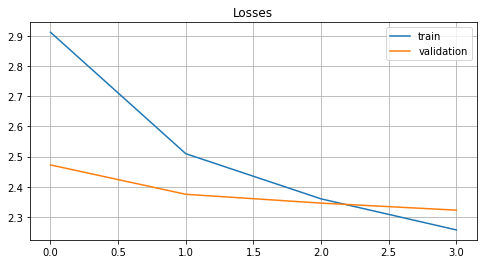

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 4))

plt.title('Losses')
plt.plot(np.arange(len(train_losses)), train_losses, val_losses)
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [0]:
def predict_on_batch(batch):
    with torch.no_grad():
        res, _ = model(batch)

        probs = torch.FloatTensor(batch.shape)

        for word_idx in range(batch.shape[0]):
          for letter_idx in range(batch.shape[1]):
            probs[word_idx][letter_idx] = res[word_idx][letter_idx][batch[word_idx][letter_idx].item()].exp()
          
        return probs

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

In [0]:
batch_size = 64
probs = []
words = []

for x, y in DataLoader(train_dataset, batch_size=batch_size, collate_fn=Padder(pad_symbol=PAD_TOKEN)):
  probs += [x for x in predict_on_batch(x)]
  words += [a for a in x]

In [0]:
for i in range(1, 5):
  print(*filter(lambda x: True if x[0] not in ('PAD', 'BEGIN') else False, zip(vocab.get_word(words[-i].numpy()), probs[-i].tolist())), sep='\n')
  print('=' * 30)

('begin', 9.475422848481685e-05)
('з', 0.0014893952757120132)
('а', 0.001547430525533855)
('ш', 0.007255144417285919)
('у', 0.0007814340060576797)
('р', 0.002415482886135578)
('ш', 0.0011428218567743897)
('а', 8.764921949477866e-05)
('л', 0.006580594927072525)
('и', 0.0066396621987223625)
('pad', 0.0006807434838265181)
('pad', 0.0023838221095502377)
('begin', 9.475422848481685e-05)
('о', 0.003552214941009879)
('б', 0.005117836408317089)
('н', 0.006876885425299406)
('а', 0.00020569880143739283)
('г', 0.00019328958296682686)
('л', 0.001841068733483553)
('е', 0.002841937355697155)
('л', 0.0055078864097595215)
('а', 0.00013249905896373093)
('pad', 0.0002899827959481627)
('pad', 0.002191781299188733)
('begin', 9.475422848481685e-05)
('м', 0.0007561749662272632)
('я', 0.006634984165430069)
('с', 0.03600360453128815)
('н', 0.0012148921377956867)
('ы', 0.0006637430051341653)
('е', 0.0031248300801962614)
('л', 0.002861730055883527)
('а', 0.0001482845254940912)
('в', 0.0005739532643929124)
('к',

**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [0]:
def generate(model, max_length=20, start_index=1, end_index=2):
    model.eval()
    sym = torch.LongTensor([start_index])
    word = ''

    for i in range(max_length):
       res, hidden = model(sym.unsqueeze(0))
       #print(res.shape)
      
       sym = torch.multinomial(res.exp().squeeze(), 1)  # uniform probabilities
       if sym.item() == end_index:
         break

       word += vocab.i2t[sym.item()]

    return word

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [0]:
for i in range(20):
    print(generate(model, max_length=20, start_index=vocab.t2i['begin'], end_index=vocab.t2i['end']))

бахнушратвама
омалёжёbeginднебулятупай
бий
эй
зем
атьбимелучую
х
стьюгасястнующисяспе
зутобый
мым
дешщичемющескувшёрни
вах
мязмый
зоть
блкахум
пативатсепобымиринол
рятрамый
побующий
сфьнх
бумтазой


**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [0]:
def generate_batch(model, batch_size, max_length = 20, start_index=1, end_index=2):
    model.eval()
    sym = torch.LongTensor([start_index] * batch_size)

    generated_sym = [] #torch.LongTensor(batch_size, max_length)
    words = np.array([[]])

    for i in range(max_length):
       res, _ = model(sym.unsqueeze(0))
       symbols = torch.multinomial(res.exp().squeeze(), 1)  # uniform probabilities
       new_let = np.array([list(map(lambda x: vocab.i2t[x.item()], symbols))])
       #print(words.shape, new_let)
       words = np.append(words, new_let)

    for letter in words:
        pass
    return words.reshape((batch_size, max_length))

**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.

In [0]:
class RNNLM_upgrade(nn.Module):
    def __init__(self, vocab_size, embeddings_dim, hidden_size, layer_num, dropout):
        super(RNNLM_upgrade, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # maybe add pad_idx
        self.GRU = nn.GRU(embeddings_dim, hidden_size, num_layers=layer_num, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)
        #self.hidden = torch.zeros(hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, inputs, hidden=None):
        inputs = self.embedding(inputs)
        output, hidden = self.GRU(inputs, self.hidden)
        output = self.softmax(self.linear(output))
        self.hidden = hidden.detach()
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        self.hidden = torch.zeros([1, batch_size, self.hidden_size])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0; iteration: 0; Loss 4.005889892578125
Epoch: 1; iteration: 0; Loss 2.584078550338745
Epoch: 2; iteration: 0; Loss 2.4657318592071533
Epoch: 3; iteration: 0; Loss 2.4130241870880127
Epoch: 4; iteration: 0; Loss 2.37808895111084


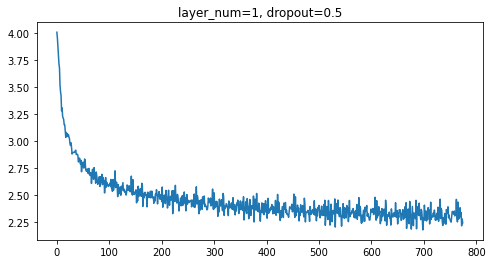

In [0]:
embedding_dim = 32
hidden_size = 16
lr = 10e-3
dropout = 0.5
layer_num = 1

num_epoch = 5
batch_size = 64
PAD_TOKEN = train_dataset.vocab([['PAD']])[0][0]

model = RNNLM_upgrade(len(train_dataset.vocab), embedding_dim, hidden_size, layer_num, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss(ignore_index=PAD_TOKEN)
losses = []

for i in range(num_epoch):
    cnt = -1
    model.init_hidden(batch_size)
    
    for x, y in DataLoader(train_dataset, batch_size=batch_size, collate_fn=Padder(pad_symbol=PAD_TOKEN)):
        curr_loss = train_on_batch(model, criterion, x, y, optimizer)
        losses.append(curr_loss)
        cnt += 1
        
        if cnt % 500 == 0:
            print('Epoch: {}; iteration: {}; Loss {}'.format(i, cnt, curr_loss))   

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(losses)), losses)
plt.title('layer_num={}, dropout={}'.format(layer_num, dropout))
plt.show()

In [0]:
for i in range(20):
    print(generate(model, max_length=20, start_index=vocab.t2i['BEGIN'], end_index=vocab.t2i['END']))

безаплитво
этолавать
идивчахе
завылев
сескранных
поголелибовашикостаю
зашках
зоикстройныМв
ниачитерими
понущитны
еталоску
мелчёнине
экродатыватися
беблохивалеслия
навесном
нетявымам
ставать
зовренитеризничекеи
майное
жезыебиястоме
